# Stochastic differential equation

## Introduction

The aim of a stochastic differential equation is to add a description of the uncertainty to a differential equation. Assume we have a simple model for an oscillator:

- $dx/dt = u$
- $du/dt = -c^2 x$
- $x(0)=x_o$ and $u(0)=0$



In [2]:
# import some useful packages first
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn #random number generator for normal or gaussian distributed variables.
from math import * #basic math functions

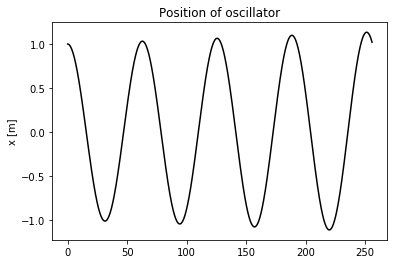

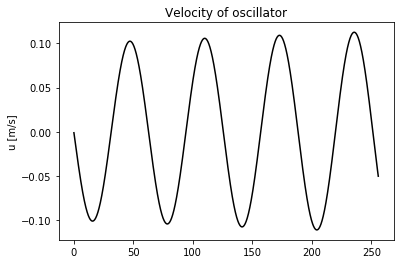

In [16]:
L=256
dt=0.1
c=0.1
t_all = np.arange(dt,L,dt)
n=len(t_all)
x=np.array([[1],[0]])
x_all=np.zeros((2,n))
A=np.array([[1.0,dt],[-c**2*dt, 1.0]]) #discretized oscillator with Euler-forward

i=0
for t in t_all:
    x=A @ x #matrix multiplication
    x_all[:,i]=x[:,0]
    i=i+1
    
plt.plot(t_all,x_all[0,:],'k-')
plt.title("Position of oscillator")
plt.ylabel('x [m]')
plt.show()

plt.plot(t_all,x_all[1,:],'k-')
plt.title("Velocity of oscillator")
plt.ylabel('u [m/s]')
plt.show()
